# Relationship Between States' Government Policy and Changes in Economy

# Overview

In our project, we explored the effect of state-wide COVID-19 policies on the respective economies of Utah, California, and Nevada, using unemployment claims, change in consumer spending, and small business revenue as measures of the state of the economy.

We concluded that there is no apparent correlation between unemployment claims and government response index in any of the states. For consumer spending, however, there is a correlation with government response index in Utah, but not in California or Nevada. We also found that there is no correlation between government response index and small business revenue in Utah. In Nevada and California, the business revenue data were skewed to begin with, so while we concluded that there may be a correlation, our determination may not be completely accurate.

# Names

 - Hana Kim
 - Emily Jewik
 - Vivian Yan
 - Andrew Pham
 - Edward De Leon

# Research Question

Do state-wide COVID-19 policies in California, Nevada, and Utah have a significant effect on that state's economy? Specifically, what effect is there, if any, of government policy on a state's unemployment rates, consumer spending, and small business revenue?

# Background and Prior Work

COVID-19 has had a large impact on everyone’s lives, and one way it has prominently changed the economy was through its adverse effect on many businesses, causing them to shut down. We were interested in finding out whether there is a relationship between the publication of COVID-19 policies and whether small businesses would be positively affected or negatively affected. Likewise, we were also concerned about other economic factors such as unemployment and consumer spending. We decided to analyze the correlation and see. For example, if there is a policy that mandates a curfew, would business suffer heavily from loss of revenue? On the other hand, if a business is suffering, will policy stringency respond to help? This is important because it could provide insight on how heavily COVID-19 related political actions affect the economy. <br> 

We decided to analyze California, Nevada, and Utah specifically because of their differences in policies and economic indices while being in around the same area to account for how COVID-19 spread to different parts of the US at different times. If we had used New York, for example, we would have to take into account that they were affected by the virus starting at a much earlier time than the west coast. <br>

In addition, studies have shown that social distancing vastly increases after a state declares an emergency. However, the extent that people in an area socially distance and decrease their mobility is tied to their economic status. For example, the study shows that areas with lower income decreased their mobility substantially less than areas with higher incomes - possibly due to worse healthcare availability or inability to work from home, to name a few reasons (1). Since economy affects how often policies are adhered to, perhaps policies may greatly impact economy. 

Another study shows that local policies did not considerably impact economy. Rather, it was state-level policies which had a greater effect. The study also mentions how jobless claim rates were similar between states which implemented stay-at-home orders and those which did not. However, the study ranged from 6 weeks before the stay-at-home order to 3 weeks after (2), so we intend to explore this further with more recent data.

## References: 

- 1) https://www.pnas.org/content/117/33/19658 <br>
- 2) https://www.nber.org/papers/w27099h <br>


# Hypothesis

We believe that COVID-19 policies are a good predictor of whether or not economic influencers such as small business revenue, consumer spending, and unemployment fluctuate. This is because those political actions limit human interaction and activity, which has a direct impact on changes in the overall economy. Specifically, we are expecting government policy to decrease consumer spending because when people move around less, they are less likely to spend money. We then assume that those policies will also decrease small business revenue and increase unemployment rates, but to less of a degree than its effect on consumer spending. This is because revenue and unemployment could also be affected by factors tied to specific businesses while consumer spending is directly related to consumer movement and activity.

# Dataset(s)

**Dataset Name: US Policy Index** <br>
Link: https://github.com/OxCGRT/covid-policy-tracker <br>
Number of Observations: 642 <br>
Description: This dataset from Oxford’s COVID-19 government response tracker provides an indexing method that quantifies and measures state political response to COVID-19. The indexing method can be found here https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md. <br>

**Dataset Name: US Economic Influencers** <br>
Link: https://github.com/OpportunityInsights/EconomicTracker <br>
Number of Observations: 1395 <br>
Description: This dataset from tracktherecovery.org provides regional descriptions of small business revenue, consumer spending, small business openings, job postings, employment, unemployment claims. <br>

The US Policy Index dataset provides us with data of the Government Response Index across states, which we will use as the measure of the stringency of COVID-19 policies. We plan to use this with the US Economic Influencers dataset, which contains data of several economic influencers across states, to explore the relationship between COVID-19 policies and each state's economy. Of the economic influencers in the dataset, we decided to focus on unemployment claim rates, consumer spending, and small business revenue. 

We combined the US Policy Index and US Economic Influencers datasets by merging them on weekly dates in order to see the change in the Policy Index and Economic Influencers over time.

# Setup

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Graphing
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('talk')
plt.rcParams["axes.labelsize"] = 18

# Statistics
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

# Data Cleaning

## COVID-19 Policy Dataset

First, we store the COVID-19 policy dataset into a dataframe. 

In [2]:
policies = pd.read_csv('https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv')

Since we need to clean the Oxford policy dataset for each of the three states, we create a function to get only the data corresponding to the state name and reset indexing.

In [3]:
# Get the dataframes for each state
def get_state_df_policy(state_name):
    
    policy_s = policies[policies.RegionName == state_name]
    policy_s = policy_s.reset_index()
    policy_s = policy_s.drop(['index'], axis=1)
    
    return policy_s

We also create a function to clean each state dataframe by dropping columns that aren't pertinent to our analysis, standardizing the date format, and filling null values that occur in September with the average of the two non-null observations before and after the null values occur. 

For the purposes of this analysis, we only keep the GovernmentResponseIndexForDisplay column because we are interested in the overall government response level; thus, we drop the economic support index column and the stringency index column, which encapsulate only a fraction of the indicators in the dataset. We drop all the individual indicators and flags as well, again because we are only interested in the overall government response level. <br>

Furthermore, we drop data prior to January since that was largely before the pandemic started gaining major traction in the United States. We drop data from November to the present as November data is very recent and could be subject to inconsistencies. 

In [4]:
# Clean policy dataset
def clean_policy_df(dataf):
    
    # standardize date
    
    dataf['Date'] = pd.to_datetime(dataf['Date'], format='%Y%m%d')
    dataf['month'] = dataf['Date'].dt.month
    
    # take necessary columns
    
    dataf = dataf[['RegionName', 
                   'Date', 
                   'month', 
                   'GovernmentResponseIndexForDisplay']]
    
    # fill nulls with average of governmentresponseindex value before nulls and after nulls to smooth
    
    row_before_nulls = dataf.at[254, 'GovernmentResponseIndexForDisplay']
    row_after_nulls = dataf.at[264, 'GovernmentResponseIndexForDisplay']
    
    avg = (row_before_nulls + row_after_nulls) / 2

    dataf['GovernmentResponseIndexForDisplay'].fillna(avg, inplace = True)
    
    # drop data from January - March and November - present
    
    dataf = dataf[(dataf['month'] > 3) & (dataf['month'] < 11)]
    
    return dataf

In [5]:
# Get each state's policy dataframes 
policy_u = get_state_df_policy('Utah')
policy_c = get_state_df_policy('California')
policy_n = get_state_df_policy('Nevada')

In [6]:
# Clean policy dataframes for each state
policy_u = clean_policy_df(policy_u)
policy_c = clean_policy_df(policy_c)
policy_n = clean_policy_df(policy_n)

In [7]:
# Cleaned policy dataframe for Utah
policy_u.head()

,RegionName,Date,month,GovernmentResponseIndexForDisplay
91,Utah,2020-04-01,4,57.78
92,Utah,2020-04-02,4,57.78
93,Utah,2020-04-03,4,57.78
94,Utah,2020-04-04,4,59.44
95,Utah,2020-04-05,4,59.44


In [8]:
# Cleaned policy dataframe for California
policy_c.head()

,RegionName,Date,month,GovernmentResponseIndexForDisplay
91,California,2020-04-01,4,68.33
92,California,2020-04-02,4,68.33
93,California,2020-04-03,4,68.33
94,California,2020-04-04,4,69.17
95,California,2020-04-05,4,69.17


In [9]:
# Cleaned policy dataframe for Nevada
policy_n.head()

,RegionName,Date,month,GovernmentResponseIndexForDisplay
91,Nevada,2020-04-01,4,60.00
92,Nevada,2020-04-02,4,60.00
93,Nevada,2020-04-03,4,61.67
94,Nevada,2020-04-04,4,61.67
95,Nevada,2020-04-05,4,61.67


# Economy Datasets

To measure the state of the economy, we will use data from unemployment claims, consumer spending, and business revenue, storing them into their respective dataframes.

In [10]:
# Unemployment Claims
ui_claims = pd.read_csv('https://raw.githubusercontent.com/OpportunityInsights/EconomicTracker/main/data/UI%20Claims%20-%20State%20-%20Weekly.csv')

# Consumer Spending
consumer_spending = pd.read_csv('https://raw.githubusercontent.com/OpportunityInsights/EconomicTracker/main/data/Affinity%20-%20State%20-%20Daily.csv')

# Business Revenue
business_revenue = pd.read_csv('https://raw.githubusercontent.com/OpportunityInsights/EconomicTracker/main/data/Womply%20Revenue%20-%20State%20-%20Daily.csv')

Similar to what we did for the Oxford policy dataset, we create a function to get each state dataframe from the economic tracker dataset and reset indexing.

In [11]:
# Get economic data for each state
def get_state_df_econ(dataf, fips):
    
    # slice state df
    
    state = dataf[dataf['statefips'] == fips]
    state = state.reset_index(level=0)
    state = state.drop(columns=['statefips', 'index'])
    
    # move date column to beginning
    
    first_col = state.pop('Date')
    state.insert(0, 'Date', first_col)
    
    return state

We create a function to standardize the date across consumer spending, unemployment rate, and small business revenue to the same format as in the Oxford policy dataset.

In [12]:
# Standardize dates
def standardize_dates_econ(dataf):
    
    # combine date into one column
    
    dataf['Date'] = dataf['year'].astype(str)
    
    # concatenate a 0 for correct format if month or day is less than 10
    
    dataf.loc[dataf['month'] < 10, 'Date'] = dataf['Date'] + '0'
    dataf['Date'] = dataf['Date'] + dataf['month'].astype(str)
    
    # if there is no day column use day_endofweek instead
    
    if 'day_endofweek' in dataf.columns:
        
        dataf.loc[dataf['day_endofweek'] < 10, 'date'] = dataf['Date'] + '0'
        dataf['Date'] = dataf['Date'] + dataf['day_endofweek'].astype(str)
        
    else:
        
        dataf.loc[dataf['day'] < 10, 'date'] = dataf['Date'] + '0'
        dataf['Date'] = dataf['Date'] + dataf['day'].astype(str)
    
    # standardize date to readable format
    
    dataf['Date'] = pd.to_datetime(dataf['Date'], format='%Y%m%d')
    
    # drop unnecessary date columns
    
    if 'day_endofweek' in dataf.columns:
        
        dataf = dataf.drop(columns=['year', 'day_endofweek', 'date'])
        
    else:
        
        dataf = dataf.drop(columns=['year', 'day', 'date'])
    
    return dataf

Now, we create a function to clean the unemployment claims dataframe, and drop the unnecessary columns. We only consider the continued unemployment claims rate column because continued claims are less volatile than initial claims over time, and more indicative of the actual unemployment rate.

In [13]:
# Clean unemployment claims dataset
def clean_ui_claims(dataf):
    
    # standardize date

    dataf = standardize_dates_econ(dataf)
    
    # take necessary columns
    
    dataf = dataf[['Date', 'month', 'statefips', 'contclaims_rate_combined']]
    
    return dataf

In [14]:
# Clean UI dataset
ui_claims = clean_ui_claims(ui_claims)

# Get each state's ui dataframe
ui_u = get_state_df_econ(ui_claims, 49)
ui_c = get_state_df_econ(ui_claims, 6)
ui_n = get_state_df_econ(ui_claims, 32)

In [15]:
# Cleaned UI dataframe for Utah
ui_u.head()

,Date,month,contclaims_rate_combined
0,2020-01-04,1,.705
1,2020-01-11,1,.733
2,2020-01-18,1,.75
3,2020-01-25,1,.75
4,2020-02-01,2,.738


In [16]:
# Cleaned UI dataframe for California
ui_c.head()

,Date,month,contclaims_rate_combined
0,2020-01-04,1,1.85
1,2020-01-11,1,1.84
2,2020-01-18,1,1.94
3,2020-01-25,1,1.73
4,2020-02-01,2,2


In [17]:
# Cleaned UI dataframe for Nevada
ui_n.head()

,Date,month,contclaims_rate_combined
0,2020-01-04,1,1.35
1,2020-01-11,1,1.29
2,2020-01-18,1,1.25
3,2020-01-25,1,1.23
4,2020-02-01,2,1.24


Just like we did for unemployment claims, we create a function to clean the consumer spending dataframe, and drop the unnecessary columns. Since we are only concerned with the overall consumer spending of each state, we drop the columns pertaining to consumer spending by industry and by level of income. 

In [18]:
# Clean consumer spending dataset
def clean_consumer_spending(dataf):
    
    # standardize date
    
    dataf = standardize_dates_econ(dataf)
    
    # take necessary columns
    
    dataf = dataf[['Date', 'month', 'statefips', 'spend_all']] 
    
    return dataf

In [19]:
# Clean consumer spending dataset
consumer_spending = clean_consumer_spending(consumer_spending)

# Get consumer spending dataframe for each state
consumer_spending_u = get_state_df_econ(consumer_spending, 49)
consumer_spending_c = get_state_df_econ(consumer_spending, 6)
consumer_spending_n = get_state_df_econ(consumer_spending, 32)

In [20]:
# Cleaned consumer dataframe for Utah
consumer_spending_u.tail()

,Date,month,spend_all
323,2020-11-19,11,-.0458
324,2020-11-20,11,-.0344
325,2020-11-21,11,-.0412
326,2020-11-22,11,-.0469
327,2020-11-29,11,-.135


In [21]:
# Cleaned consumer dataframe for California
consumer_spending_c.tail()

,Date,month,spend_all
323,2020-11-19,11,-.0708
324,2020-11-20,11,-.073
325,2020-11-21,11,-.0793
326,2020-11-22,11,-.0822
327,2020-11-29,11,-.166


In [22]:
# Cleaned consumer dataframe for Nevada
consumer_spending_n.tail()

,Date,month,spend_all
323,2020-11-19,11,-.0981
324,2020-11-20,11,-.09
325,2020-11-21,11,-.0967
326,2020-11-22,11,-.1
327,2020-11-29,11,-.216


Next, we create a function to clean the small business revenue dataframe, and drop the unnecessary columns. Since we are only concerned with the overall small business revenue of each state, we drop the columns pertaining to small business revenue by income level (low, middle, high) of zipcodes and specific business sectors.

In [23]:
# Clean business revenue dataset
def clean_business_revenue(dataf):
    
    # standardize date
    
    dataf = standardize_dates_econ(dataf)
    
    # take necessary columns
    
    dataf = dataf[['Date', 'month', 'statefips', 'revenue_all']]
    
    return dataf

In [24]:
# Clean business revenue dataset
business_revenue = clean_business_revenue(business_revenue)

# Get each state's business revenue dataframe
business_revenue_u = get_state_df_econ(business_revenue, 49)
business_revenue_c = get_state_df_econ(business_revenue, 6)
business_revenue_n = get_state_df_econ(business_revenue, 32)

In [25]:
# Cleaned business revenue dataset for Utah
business_revenue_u.head()

,Date,month,revenue_all
0,2020-01-10,1,-0.00832
1,2020-01-11,1,0.01130
2,2020-01-12,1,0.00409
3,2020-01-13,1,-0.01700
4,2020-01-14,1,-0.02280


In [26]:
# Cleaned business revenue dataset for California
business_revenue_c.head()

,Date,month,revenue_all
0,2020-01-10,1,-0.00614
1,2020-01-11,1,0.00528
2,2020-01-12,1,0.00343
3,2020-01-13,1,-0.01220
4,2020-01-14,1,-0.00506


In [27]:
# Cleaned business revenue dataset for Nevada
business_revenue_n.head()

,Date,month,revenue_all
0,2020-01-10,1,-0.0495
1,2020-01-11,1,-0.0305
2,2020-01-12,1,-0.0254
3,2020-01-13,1,-0.0442
4,2020-01-14,1,-0.0437


## Merge Policy and Economic Datasets

Now that the policy and economic datasets are all cleaned, we want to merge the datasets together for each state. <br> 

We create a function to merge the government response index column, consumer spending column, unemployment claim rate column, and small business revenue column on the date column for each state. The inner merge only preserves weekly data, as the unemployment claim rate column was originally daily while the others were weekly. This makes it easier to see the actual changes in the variables we are interested in since many of the same observations in the daily data were repeated across several days at a time. Additionally, it is better to merge each column into a single state dataframe for ease of use in analysis.

Within the merge function, we also omit the rows where '.' is present as this symbol represents null values in the economic tracker dataset. 

In [28]:
# Merge policy and economy datasets
def merge_on_date(policy_df, ui_df, consumer_spending_df, business_revenue_df):
    
    # merge the policy dataset with the economic tracker dataset
    
    merge_df = policy_df.merge(ui_df, on='Date')
    merge_df = merge_df.merge(consumer_spending_df, on='Date')
    merge_df = merge_df.merge(business_revenue_df, on='Date')
    
    # drop null values in economic tracker dataset denoted by '.'
    
    merge_df = merge_df[(merge_df['spend_all'] != '.') & (merge_df['contclaims_rate_combined'] != '.') & (merge_df['revenue_all'] != '.')].reset_index()
    merge_df = merge_df.drop(columns=['index'])
        
    return merge_df

In [29]:
# Merge Utah policy and economic datasets
u_merge = merge_on_date(policy_u, ui_u, consumer_spending_u, business_revenue_u)
u_merge.head()

,RegionName,Date,month_x,GovernmentResponseIndexForDisplay,month_y,contclaims_rate_combined,month_x,spend_all,month_y,revenue_all
0,Utah,2020-04-04,4,59.44,4,2.81,4,-.266,4,-0.351
1,Utah,2020-04-11,4,59.44,4,4.53,4,-.26,4,-0.302
2,Utah,2020-04-18,4,56.11,4,5.49,4,-.268,4,-0.275
3,Utah,2020-04-25,4,56.11,4,5.57,4,-.206,4,-0.222
4,Utah,2020-05-02,5,52.22,5,5.78,5,-.137,5,-0.181


In [30]:
# Merge California policy and economic datasets
c_merge = merge_on_date(policy_c, ui_c, consumer_spending_c, business_revenue_c)
c_merge.head()

,RegionName,Date,month_x,GovernmentResponseIndexForDisplay,month_y,contclaims_rate_combined,month_x,spend_all,month_y,revenue_all
0,California,2020-04-04,4,69.17,4,5.55,4,-.338,4,-0.491
1,California,2020-04-11,4,70.83,4,7.37,4,-.356,4,-0.524
2,California,2020-04-18,4,70.83,4,12.5,4,-.365,4,-0.471
3,California,2020-04-25,4,73.06,4,9.72,4,-.311,4,-0.426
4,California,2020-05-02,5,73.06,5,27.5,5,-.293,5,-0.398


In [31]:
# Merge Nevada policy and economic datasets
n_merge = merge_on_date(policy_n, ui_n, consumer_spending_n, business_revenue_n)
n_merge.head()

,RegionName,Date,month_x,GovernmentResponseIndexForDisplay,month_y,contclaims_rate_combined,month_x,spend_all,month_y,revenue_all
0,Nevada,2020-04-04,4,61.67,4,8.5,4,-.341,4,-0.539
1,Nevada,2020-04-11,4,61.67,4,12.3,4,-.345,4,-0.556
2,Nevada,2020-04-18,4,61.67,4,15,4,-.363,4,-0.488
3,Nevada,2020-04-25,4,61.67,4,17.8,4,-.307,4,-0.459
4,Nevada,2020-05-02,5,62.78,5,19.7,5,-.254,5,-0.416


After merging, there are no null values left in any of the state dataframes as shown below.

In [32]:
u_merge[u_merge.isnull().any(axis=1)]

,RegionName,Date,month_x,GovernmentResponseIndexForDisplay,month_y,contclaims_rate_combined,month_x,spend_all,month_y,revenue_all


In [33]:
c_merge[c_merge.isnull().any(axis=1)]

,RegionName,Date,month_x,GovernmentResponseIndexForDisplay,month_y,contclaims_rate_combined,month_x,spend_all,month_y,revenue_all


In [34]:
n_merge[n_merge.isnull().any(axis=1)]

,RegionName,Date,month_x,GovernmentResponseIndexForDisplay,month_y,contclaims_rate_combined,month_x,spend_all,month_y,revenue_all


The inner merge of the policy and economic datasets included duplicate month columns, so we can drop all but one for analysis. 

In [35]:
def remove_dupe(df):
    
    # Remove duplicate columns
    
    df = df.T.drop_duplicates().T
    df = df.rename(columns={'month_x' : 'Month'})
    
    return df

In [36]:
# Drop duplicate month columns 
u_merge = remove_dupe(u_merge)
c_merge = remove_dupe(c_merge)
n_merge = remove_dupe(n_merge)

Now that the datasets are merged for each state, there's one last thing we need to do before we conduct analysis: convert the variables we want to explore from strings to floats for ease of plotting and analysis. Below, we have a function to convert the values of unemployment claims, consumer spending, business revenue, and government response index to floats, as these are the variables we are focusing on.

In [37]:
# Convert from string to float
def convert_to_float(data_f):
    
    # convert columns to float for analysis
    
    data_f['contclaims_rate_combined'] = data_f['contclaims_rate_combined'].astype(float)
    data_f['spend_all'] = data_f['spend_all'].astype(float)
    data_f['revenue_all'] = data_f['revenue_all'].astype(float)
    data_f['GovernmentResponseIndexForDisplay'] = data_f['GovernmentResponseIndexForDisplay'].astype(float)
        
    return data_f

In [38]:
u_merge = convert_to_float(u_merge)
c_merge = convert_to_float(c_merge)
n_merge = convert_to_float(n_merge)

# Initial Exploratory Data Analysis

To see the relationship between the variables we are interested in over time, we will first make a few exploratory plots, and then explore each variable more in-depth in our analysis.

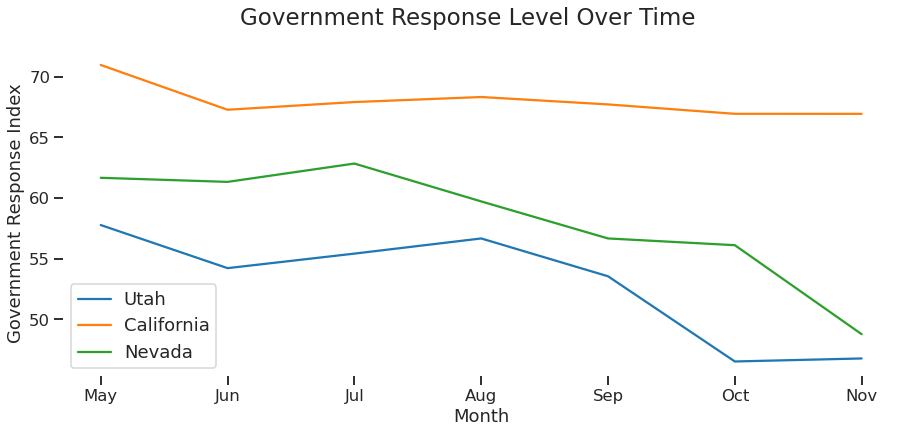

In [39]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(15,6))
    sns.lineplot(data=u_merge, x='Month', y='GovernmentResponseIndexForDisplay', label='Utah', ci=None)
    sns.lineplot(data=c_merge, x='Month', y='GovernmentResponseIndexForDisplay', label='California', ci=None)
    sns.lineplot(data=n_merge, x='Month', y='GovernmentResponseIndexForDisplay', label='Nevada', ci=None)
    plt.setp(ax.get_legend().get_texts(), fontsize='18')
    ax.set_xticklabels(['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'])
    plt.xlabel("Month", fontsize=18)
    plt.ylabel("Government Response Index", fontsize=18)
    fig.suptitle('Government Response Level Over Time', fontsize=23)
    sns.despine(top=True, right=True, left=True, bottom=True)

We can see from the plot that California has the highest government response index, with Nevada in the middle and Utah on the lower end. Interestingly in Utah and Nevada, we see the government response index gradually get very low while California stays at similar government response index levels throughout these months.

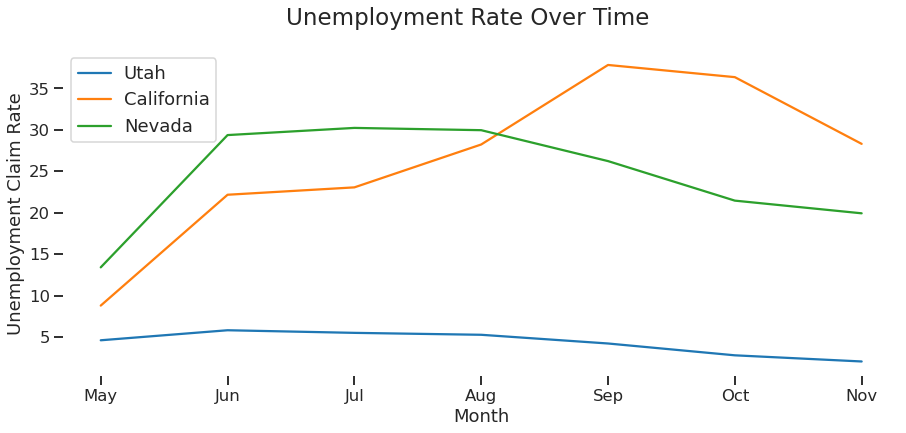

In [40]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(15,6))
    sns.lineplot(data=u_merge, x='Month', y='contclaims_rate_combined', label='Utah', ci=None)
    sns.lineplot(data=c_merge, x='Month', y='contclaims_rate_combined', label='California', ci=None)
    sns.lineplot(data=n_merge, x='Month', y='contclaims_rate_combined', label='Nevada', ci=None)
    plt.setp(ax.get_legend().get_texts(), fontsize='18')
    ax.set_xticklabels(['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'])
    plt.xlabel("Month", fontsize=18)
    plt.ylabel("Unemployment Claim Rate", fontsize=18)
    fig.suptitle('Unemployment Rate Over Time', fontsize=23)
    sns.despine(top=True, right=True, left=True, bottom=True)

Utah's unemployment claim rate is rather low in comparison to that of Nevada and California, which is interesting considering that Utah had the lowest average goverment response. The unemployment claim rates for California and Nevada are several magnitudes higher than Utah's unemployment claim rate during the same time periods, which is also something to take into consideration. Additionally while the unemployment claim rate for Nevada is higher than those for California in the earlier months of the pandemic, in the later months California overtakes Nevada. 

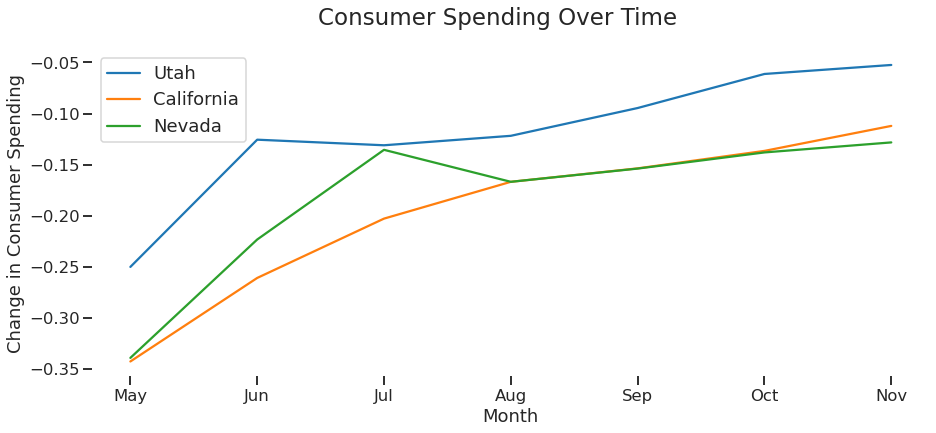

In [41]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(15,6))
    sns.lineplot(data=u_merge, x='Month', y='spend_all', label='Utah', ci=None)
    sns.lineplot(data=c_merge, x='Month', y='spend_all', label='California', ci=None)
    sns.lineplot(data=n_merge, x='Month', y='spend_all', label='Nevada', ci=None)
    plt.setp(ax.get_legend().get_texts(), fontsize='18')
    ax.set_xticklabels(['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'])
    plt.xlabel("Month", fontsize=18)
    plt.ylabel("Change in Consumer Spending", fontsize=18)
    fig.suptitle('Consumer Spending Over Time', fontsize=23)
    sns.despine(top=True, right=True, left=True, bottom=True)

We see that there were higher levels of consumer spending in Utah in comparison to California and Nevada. All three states gradually increase in consumer spending levels over time.

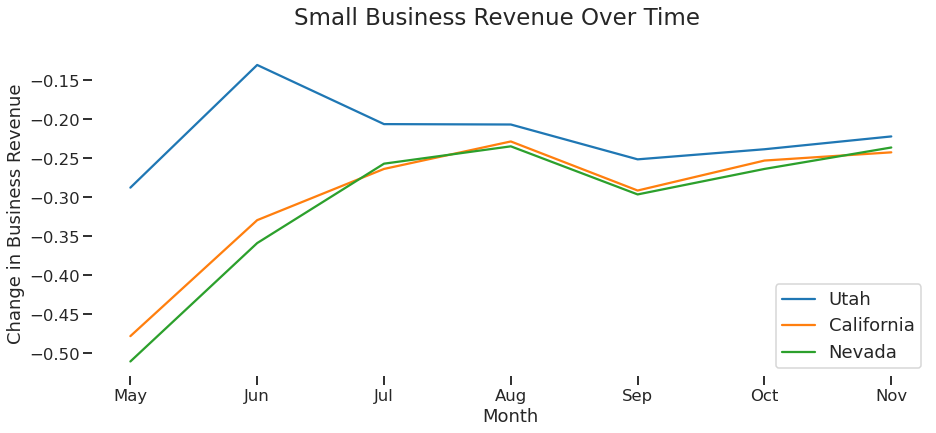

In [42]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(15,6))
    sns.lineplot(data=u_merge, x='Month', y='revenue_all', label='Utah', ci=None)
    sns.lineplot(data=c_merge, x='Month', y='revenue_all', label='California', ci=None)
    sns.lineplot(data=n_merge, x='Month', y='revenue_all', label='Nevada', ci=None)
    plt.setp(ax.get_legend().get_texts(), fontsize='18')
    ax.set_xticklabels(['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'])
    plt.xlabel("Month", fontsize=18)
    plt.ylabel("Change in Business Revenue", fontsize=18)
    fig.suptitle('Small Business Revenue Over Time', fontsize=23)
    sns.despine(top=True, right=True, left=True, bottom=True)

We see here that California and Nevada's small business revenue levels increase over time overall, starting at a low point in the earlier months of the pandemic. Utah starts at a much higher level in the early months, but small business revenue levels are similar across all three states at the start of November. 

On the whole, Utah seems to do better economically in the earlier months of the pandemic than the other two states. Additionally, the government response levels for Nevada and California are generally higher than that of Utah. These are observations worth noting and taking into account when we analyze our data.

# Data Analysis & Results

## Unemployment Rate Analysis

First, we will analyze government policy's effect on state unemployment rates. We will first look at the distributions of our state data to gain better understanding of it.

Text(0, 0.5, 'Density')

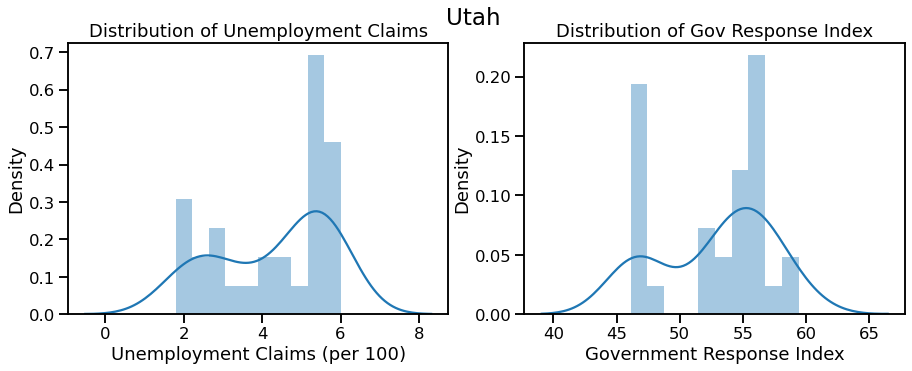

In [43]:
fig, ax =plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Utah', fontsize=23)

# Utah unemployment claims distribution
u_cont = sns.distplot(u_merge['contclaims_rate_combined'], bins=10, ax=ax[0]).set_title('Distribution of Unemployment Claims', fontsize=18)
ax[0].set_xlabel('Unemployment Claims (per 100)', fontsize=18)
ax[0].set_ylabel('Density', fontsize=18)

# Utah gov response index distribution
u_gov = sns.distplot(u_merge['GovernmentResponseIndexForDisplay'], bins=10, ax=ax[1]).set_title('Distribution of Gov Response Index', fontsize=18)
ax[1].set_xlabel('Government Response Index', fontsize=18)
ax[1].set_ylabel('Density', fontsize=18)

Text(0, 0.5, 'Density')

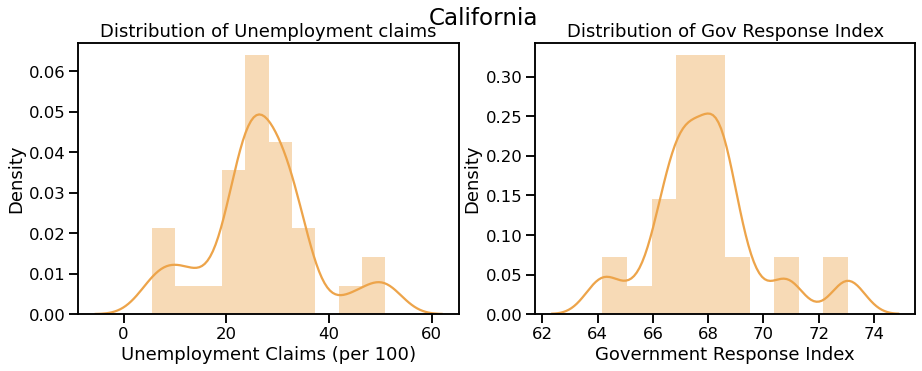

In [44]:
fig, ax =plt.subplots(1,2, figsize=(15,5))
fig.suptitle('California', fontsize=23)

# Utah unemployment claims distribution
c_cont = sns.distplot(c_merge['contclaims_rate_combined'], bins=10, ax=ax[0], color='#eda44a').set_title('Distribution of Unemployment claims', fontsize=18)
ax[0].set_xlabel('Unemployment Claims (per 100)', fontsize=18)
ax[0].set_ylabel('Density', fontsize=18)

# Utah gov response index distribution
c_gov = sns.distplot(c_merge['GovernmentResponseIndexForDisplay'], bins=10, ax=ax[1], color='#eda44a').set_title('Distribution of Gov Response Index', fontsize=18)
ax[1].set_xlabel('Government Response Index', fontsize=18)
ax[1].set_ylabel('Density', fontsize=18)

Text(0, 0.5, 'Density')

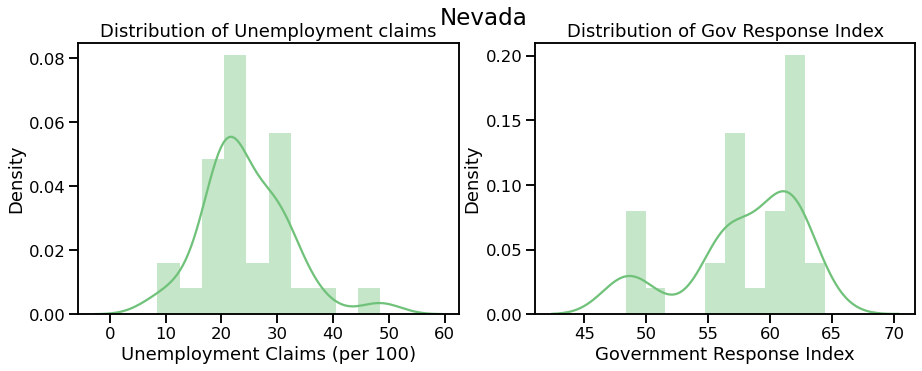

In [45]:
fig, ax =plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Nevada', fontsize=23)

# Utah unemployment claims distribution
n_cont = sns.distplot(n_merge['contclaims_rate_combined'], bins=10, ax=ax[0], color='#70c27a').set_title('Distribution of Unemployment claims', fontsize=18)
ax[0].set_xlabel('Unemployment Claims (per 100)', fontsize=18)
ax[0].set_ylabel('Density', fontsize=18)

# Utah gov response index distribution
n_gov = sns.distplot(n_merge['GovernmentResponseIndexForDisplay'], bins=10, ax=ax[1], color='#70c27a').set_title('Distribution of Gov Response Index', fontsize=18)
ax[1].set_xlabel('Government Response Index', fontsize=18)
ax[1].set_ylabel('Density', fontsize=18)

In [46]:
# Normal test for unemployment and gov response for utah, cal, nev
st_u_cont, p_u_cont = stats.normaltest(u_merge['contclaims_rate_combined'].values)
st_u_gov, p_u_gov = stats.normaltest(u_merge['GovernmentResponseIndexForDisplay'].values)
st_c_cont, p_c_cont = stats.normaltest(c_merge['contclaims_rate_combined'].values)
st_c_gov, p_c_gov = stats.normaltest(c_merge['GovernmentResponseIndexForDisplay'].values)
st_n_cont, p_n_cont = stats.normaltest(n_merge['contclaims_rate_combined'].values)
st_n_gov, p_n_gov = stats.normaltest(n_merge['GovernmentResponseIndexForDisplay'].values)

print('Utah continued unemployment claims normal test p-value: ' + str(p_u_cont))
print('Utah gov response index normal test p-value: ' + str(p_u_gov))
print('California continued unemployment claims normal test p-value: ' + str(p_c_cont))
print('California gov response index normal test p-value: ' + str(p_c_gov))
print('Nevada continued unemployment claims normal test p-value: ' + str(p_n_cont))
print('Nevada gov response index normal test p-value: ' + str(p_n_gov))

Utah continued unemployment claims normal test p-value: 0.0026959425167067206
Utah gov response index normal test p-value: 0.03762989930015811
California continued unemployment claims normal test p-value: 0.4382434677741983
California gov response index normal test p-value: 0.06569097312114523
Nevada continued unemployment claims normal test p-value: 0.022435906416691454
Nevada gov response index normal test p-value: 0.08207085942294824


When analyzing the states' unemployment values and government response indexes, all values pass the test for normality with alpha value 0.01 except for Utah's unemployment distribution. However, after observing the details of the distribution plots, we can see that Utah's unemployment claims span a small and low area of between 1 to 6 unemployment claims per 100 people while other states' unemployment claim values are in the range of around 10 to 50. Therefore, any small variability in Utah's values are magnified to seem significant, when in reality all the claim rates are close together. We can also see that the states with more variable unemployment rates had normal distributions, so we can assume that unemployment rates are distributed approximately normally in general. 

As a side note, Utah's low unemployment rates were one of the reasons we chose to analyze Utah in the first place, so we will be continuing with the analysis of these values to stay consistent with the other states' values. However, we will keep in mind that the OLS regression will not be wholely accurate due to the unique nature of this distribution. 

In [47]:
out_u, pred_u = patsy.dmatrices('contclaims_rate_combined ~ GovernmentResponseIndexForDisplay', u_merge)
mod_u = sm.OLS(out_u, pred_u)
res_u = mod_u.fit()
print(res_u.summary())

                               OLS Regression Results                               
Dep. Variable:     contclaims_rate_combined   R-squared:                       0.583
Model:                                  OLS   Adj. R-squared:                  0.569
Method:                       Least Squares   F-statistic:                     40.61
Date:                      Sun, 13 Dec 2020   Prob (F-statistic):           5.76e-07
Time:                              21:28:25   Log-Likelihood:                -41.272
No. Observations:                        31   AIC:                             86.54
Df Residuals:                            29   BIC:                             89.41
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

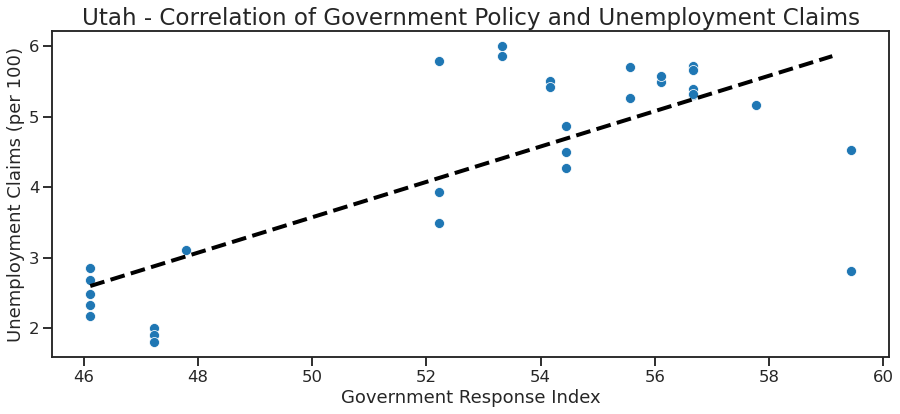

In [48]:
#Plot best fit line
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(15,6))
    sns.scatterplot(x='GovernmentResponseIndexForDisplay', y='contclaims_rate_combined', data=u_merge, s=100).set_title('Utah - Correlation of Government Policy and Unemployment Claims', fontsize=23)
    plt.xlabel('Government Response Index', fontsize=18)
    plt.ylabel('Unemployment Claims (per 100)', fontsize=18)
    x = np.arange(u_merge['GovernmentResponseIndexForDisplay'].min(), u_merge['GovernmentResponseIndexForDisplay'].max())
    y = 0.2505 * x + -8.9510
    plt.plot(x,y,'--k',linewidth=4)

The p-value of our model is less than 0.01 so that means we reject the null hypothesis in favor of the alternate hypothesis that there is a relationship between Utah unemployment rate and government response index. The r-squared is 0.583 which means that we can explain 58.3% of the variation in the unemployment rates with our model. However, we must remember that our unemployment data for Utah was not normally distributed and so we must look at other states' data to truly see correlation.

In [49]:
out_c, pred_c = patsy.dmatrices('contclaims_rate_combined ~ GovernmentResponseIndexForDisplay', c_merge)
mod_c = sm.OLS(out_c, pred_c)
res_c = mod_c.fit()
print(res_c.summary())

                               OLS Regression Results                               
Dep. Variable:     contclaims_rate_combined   R-squared:                       0.153
Model:                                  OLS   Adj. R-squared:                  0.123
Method:                       Least Squares   F-statistic:                     5.226
Date:                      Sun, 13 Dec 2020   Prob (F-statistic):             0.0297
Time:                              21:28:26   Log-Likelihood:                -113.88
No. Observations:                        31   AIC:                             231.8
Df Residuals:                            29   BIC:                             234.6
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

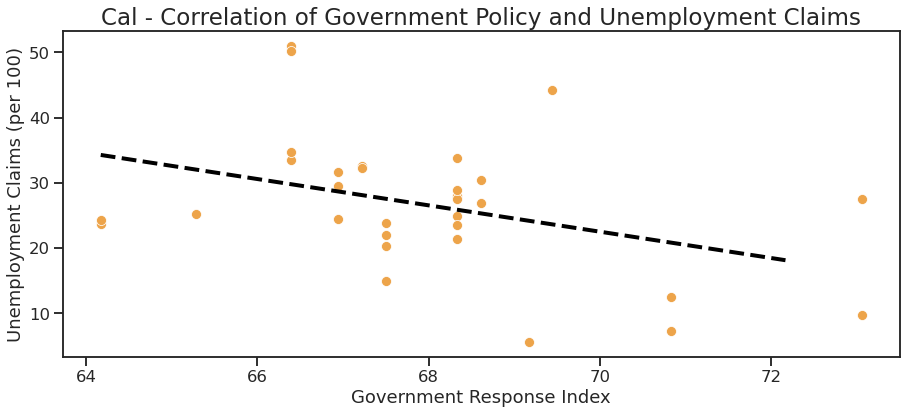

In [50]:
#Plot best fit line
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(15,6))
    sns.scatterplot(x='GovernmentResponseIndexForDisplay', y='contclaims_rate_combined', data=c_merge, s=100, color='#eda44a').set_title('Cal - Correlation of Government Policy and Unemployment Claims', fontsize=23)
    plt.xlabel('Government Response Index', fontsize=18)
    plt.ylabel('Unemployment Claims (per 100)', fontsize=18)
    x = np.arange(c_merge['GovernmentResponseIndexForDisplay'].min(), c_merge['GovernmentResponseIndexForDisplay'].max())
    y = -2.0170 * x + 163.7253
    plt.plot(x,y,'--k',linewidth=4)

Observing a low r-squared value of 0.153 and p-value > 0.01 suggests that our model has low predictive power and we accept the null hypothesis that there is no relationship between California's unemployment rate and its government response index. 

In [51]:
out_n, pred_n = patsy.dmatrices('contclaims_rate_combined ~ GovernmentResponseIndexForDisplay', n_merge)
mod_n = sm.OLS(out_n, pred_n)
res_n = mod_n.fit()
print(res_n.summary())

                               OLS Regression Results                               
Dep. Variable:     contclaims_rate_combined   R-squared:                       0.053
Model:                                  OLS   Adj. R-squared:                  0.021
Method:                       Least Squares   F-statistic:                     1.629
Date:                      Sun, 13 Dec 2020   Prob (F-statistic):              0.212
Time:                              21:28:26   Log-Likelihood:                -105.97
No. Observations:                        31   AIC:                             215.9
Df Residuals:                            29   BIC:                             218.8
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

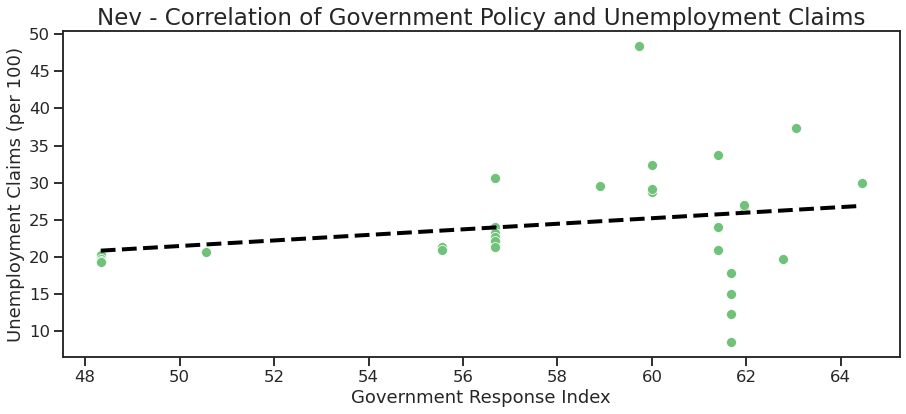

In [52]:
#Plot best fit line
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(15,6))
    sns.scatterplot(x='GovernmentResponseIndexForDisplay', y='contclaims_rate_combined', data=n_merge, s=100, color='#70c27a').set_title('Nev - Correlation of Government Policy and Unemployment Claims', fontsize=23)
    plt.xlabel('Government Response Index', fontsize=18)
    plt.ylabel('Unemployment Claims (per 100)', fontsize=18)
    x = np.arange(n_merge['GovernmentResponseIndexForDisplay'].min(), n_merge['GovernmentResponseIndexForDisplay'].max())
    y = 0.3742 * x + 2.7700
    plt.plot(x,y,'--k',linewidth=4)

Again, a low r-squared value of 0.053 and p-value > 0.01 suggests that our model has low predictive power and we accept the null hypothesis that there is no relationship between Nevada's unemployment rate and its government response index. 

Observing that only our model for Utah showed a relationship between the unemployment rate and the government response index and Utah's unemployment data was very close together and not even normally distributed, we cannot make the claim that California's, Utah's, or Nevada's government response index has any relationship with the unemployment claim rates in that state.

# Consumer Spending Analysis

We also want to take a look at the distrbutions of consumer spending for each state before beginning our analysis. We can assume that the distributions of the Government Reponse Index is normal for each state from the normality test we performed above.

Text(0, 0.5, 'Density')

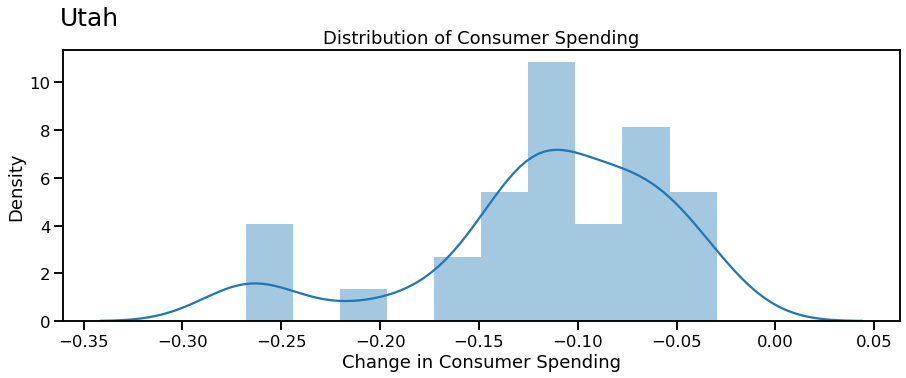

In [53]:
fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle('Utah', fontsize=25, x=0.15, y=1, verticalalignment='top')

# Utah consumer spending distribution
u_cs = sns.distplot(u_merge['spend_all'], bins=10).set_title('Distribution of Consumer Spending', fontsize=18)
plt.xlabel("Change in Consumer Spending", fontsize=18)
plt.ylabel("Density", fontsize=18)

Text(0, 0.5, 'Density')

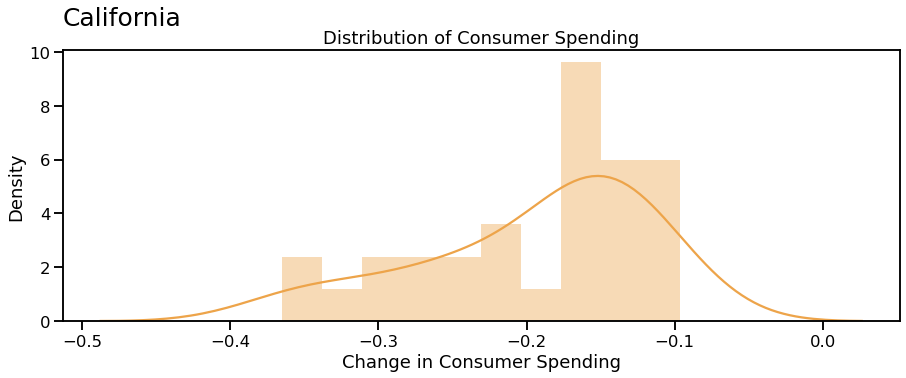

In [54]:
fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle('California', fontsize=25, x=0.18, y=1, verticalalignment='top')

# California consumer spending distribution

c_cs = sns.distplot(c_merge['spend_all'], bins=10, color='#eda44a').set_title('Distribution of Consumer Spending', fontsize=18)
plt.xlabel("Change in Consumer Spending", fontsize=18)
plt.ylabel("Density", fontsize=18)

Text(0, 0.5, 'Density')

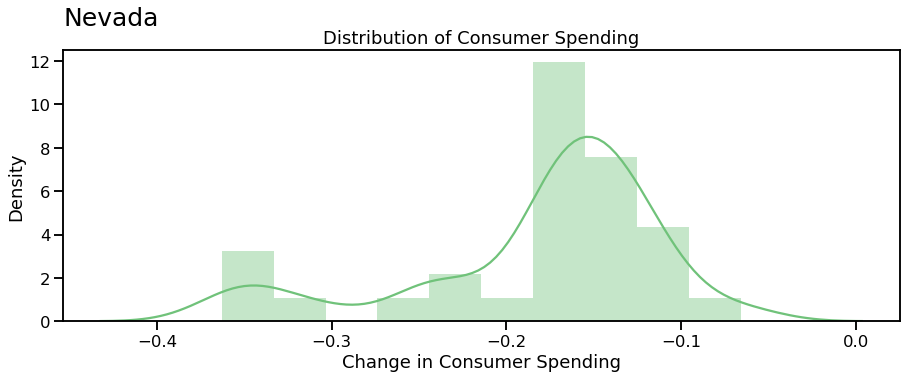

In [55]:
fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle('Nevada', fontsize=25, x=0.17, y=1, verticalalignment='top')

# Nevada consumer spending distribution

u_cs = sns.distplot(n_merge['spend_all'], bins=10, color='#70c27a').set_title('Distribution of Consumer Spending', fontsize=18)
plt.xlabel("Change in Consumer Spending", fontsize=18)
plt.ylabel("Density", fontsize=18)

In [56]:
# Normal test for consumer spending and gov response for utah, cal, nev
st_u_cs, p_u_cs = stats.normaltest(u_merge['spend_all'].values)
st_c_cs, p_c_cs = stats.normaltest(c_merge['spend_all'].values)
st_n_cs, p_n_cs = stats.normaltest(n_merge['spend_all'].values)

print('Utah consumer spending normal test p-value: ' + str(p_u_cs))
print('California consumer spending normal test p-value: ' + str(p_c_cs))
print('Nevada consumer spending normal test p-value: ' + str(p_n_cs))

Utah consumer spending normal test p-value: 0.021265694653180088
California consumer spending normal test p-value: 0.12113170374303796
Nevada consumer spending normal test p-value: 0.012610966184845558


Change in consumer spending passes the test for normality with an alpha value of 0.01 for all three states, as we fail to reject the null. Consumer spending values all fall into a negative range, likely because consumers are wary of making purchases in the middle of the pandemic. More values seem to fall into the comparatively higher -.05 to -.1 range for Utah which could indicate that consumers spent more in Utah than California or Nevada during the pandemic. We pass the test for normality so we proceed with OLS regression. 

For all three states, we will perform OLS regression to see if there is a correlation between consumer spending and government response level and plot a best fit line. 

In [57]:
outcome_cs_u, predictors_cs_u = patsy.dmatrices('spend_all ~ GovernmentResponseIndexForDisplay', u_merge)
mod_cs_u = sm.OLS(outcome_cs_u, predictors_cs_u)
res_cs_u = mod_cs_u.fit()

In [58]:
print(res_cs_u.summary())

                            OLS Regression Results                            
Dep. Variable:              spend_all   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     37.27
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           1.20e-06
Time:                        21:28:29   Log-Likelihood:                 54.783
No. Observations:                  31   AIC:                            -105.6
Df Residuals:                      29   BIC:                            -102.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

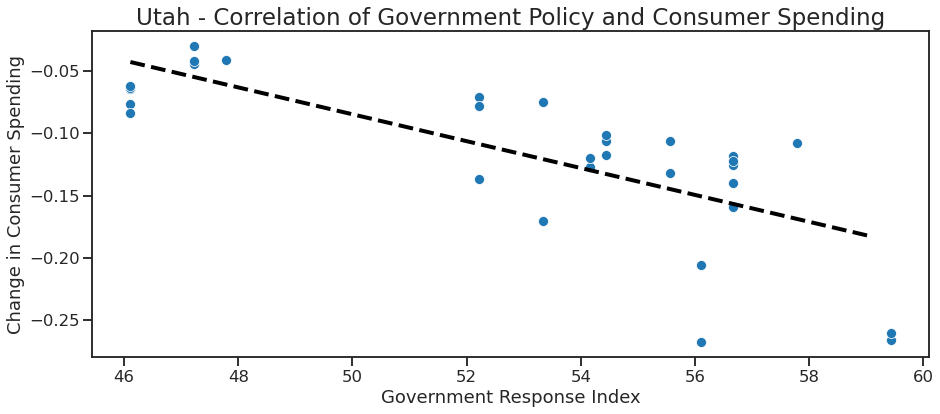

In [59]:
# Plot best fit line
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(15,6))
    sns.scatterplot(x='GovernmentResponseIndexForDisplay', y='spend_all', data=u_merge, s=100).set_title('Utah - Correlation of Government Policy and Consumer Spending', fontsize=23)
    plt.xlabel('Government Response Index')
    plt.ylabel('Change in Consumer Spending')
    x_cs_u = np.arange(u_merge['GovernmentResponseIndexForDisplay'].min(), u_merge['GovernmentResponseIndexForDisplay'].max())
    y_cs_u = -.0108 * x_cs_u + 0.4554
    plt.plot(x_cs_u, y_cs_u, '--k',linewidth=4)


Our p-value is 0.000, likely meaning that the p-value was rounded to 0 due to it being a very low p-value.  The r-squared value indicates that we can explain 56.2% of the variation of consumer spending with the model. Thus, with our alpha value of 0.01 we reject the null hypothesis and accept the alternative. We can conclude that there is a relationship between change in consumer spending in Utah and the government response index from April 2020 to September 2020.

In [60]:
outcome_cs_c, predictors_cs_c = patsy.dmatrices('spend_all ~ GovernmentResponseIndexForDisplay', c_merge)
mod_cs_c = sm.OLS(outcome_cs_c, predictors_cs_c)
res_cs_c = mod_cs_c.fit()

In [61]:
print(res_cs_c.summary())

                            OLS Regression Results                            
Dep. Variable:              spend_all   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     9.884
Date:                Sun, 13 Dec 2020   Prob (F-statistic):            0.00383
Time:                        21:28:29   Log-Likelihood:                 40.691
No. Observations:                  31   AIC:                            -77.38
Df Residuals:                      29   BIC:                            -74.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

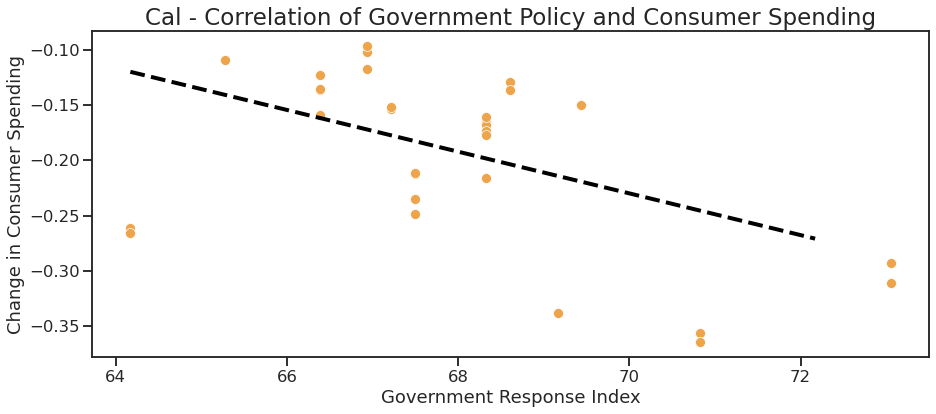

In [62]:
# Plot best fit line
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(15,6))
    sns.scatterplot(x='GovernmentResponseIndexForDisplay', y='spend_all', data=c_merge, s=100, color='#eda44a').set_title('Cal - Correlation of Government Policy and Consumer Spending', fontsize=23)
    plt.xlabel('Government Response Index')
    plt.ylabel('Change in Consumer Spending')
    x_cs_c = np.arange(c_merge['GovernmentResponseIndexForDisplay'].min(), c_merge['GovernmentResponseIndexForDisplay'].max())
    y_cs_c = -0.0189 * x_cs_c + 1.0931
    plt.plot(x_cs_c, y_cs_c, '--k',linewidth=4)


While our p-value 0.004 is less than our alpha value 0.01, indicating that there is a relationship between the government response index and consumer spending, our r-squared value is .254. Since we can only explain 25.4% of the variation of consumer spending with our model we can conclude that the model is not a very accurate predictor of change in consumer spending in California. Thus, we accept the null hypothesis that there is no relationship between consumer spending and government response index in California.

In [63]:
outcome_cs_n, predictors_cs_n = patsy.dmatrices('spend_all ~ GovernmentResponseIndexForDisplay', n_merge)
mod_cs_n = sm.OLS(outcome_cs_n, predictors_cs_n)
res_cs_n = mod_cs_n.fit()

In [64]:
print(res_cs_n.summary())

                            OLS Regression Results                            
Dep. Variable:              spend_all   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     9.794
Date:                Sun, 13 Dec 2020   Prob (F-statistic):            0.00397
Time:                        21:28:29   Log-Likelihood:                 42.100
No. Observations:                  31   AIC:                            -80.20
Df Residuals:                      29   BIC:                            -77.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

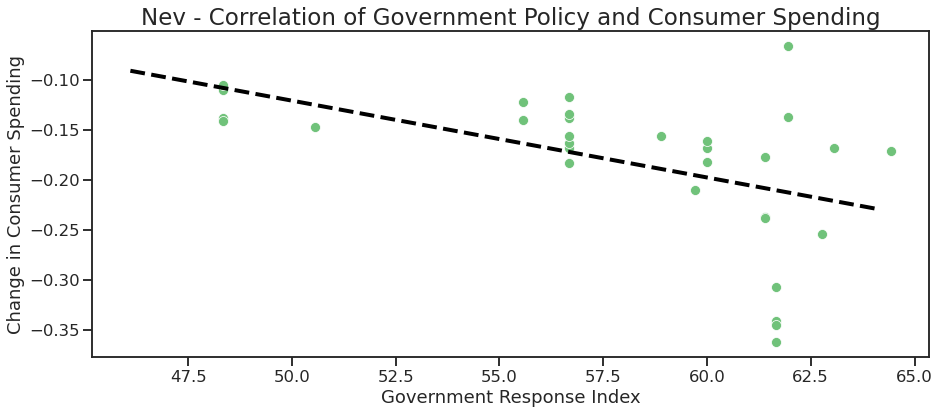

In [65]:
# Plot best fit line
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(15,6))
    sns.scatterplot(x='GovernmentResponseIndexForDisplay', y='spend_all', data=n_merge, s=100, color='#70c27a').set_title('Nev - Correlation of Government Policy and Consumer Spending', fontsize=23)
    plt.xlabel('Government Response Index')
    plt.ylabel('Change in Consumer Spending')
    x_cs_n = np.arange(u_merge['GovernmentResponseIndexForDisplay'].min(), n_merge['GovernmentResponseIndexForDisplay'].max())
    y_cs_n = -.0077 * x_cs_n + 0.2644
    plt.plot(x_cs_n, y_cs_n, '--k',linewidth=4)


Similar to California, our p-value of 0.004 is less than alpha 0.01, which indicates a relationship between Government Response Index and change in consumer spending. However, the low r-squared value of .252 indicates that only 25.2% of the variation is explained by our model, so we accept the null and conclude that there is no relationship between change in consumer spending and government response index in Nevada.  

Thus, we can only conclude that there is a relationship between consumer spending and government response index for Utah. Our r-squared values for Nevada and California indicate that we cannot explain the variation in consumer spending very accurately in those states with OLS regression.

# Business Revenue Analysis

First, we will analyze government policy's effect on states' small business revenue. We will first look at the distributions of our state data to gain better understanding of it.

Text(0, 0.5, 'Density')

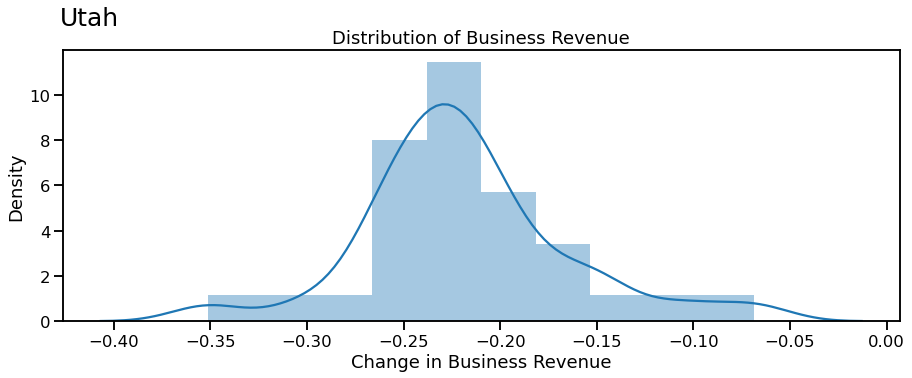

In [66]:
fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle('Utah', fontsize=25, x=0.15, y=1, verticalalignment='top')

# Utah business revenue distribution

u_rev = sns.distplot(u_merge['revenue_all'], bins=10).set_title('Distribution of Business Revenue', fontsize=23)
plt.xlabel("Change in Business Revenue", fontsize=18)
plt.ylabel("Density", fontsize=18)

Text(0, 0.5, 'Density')

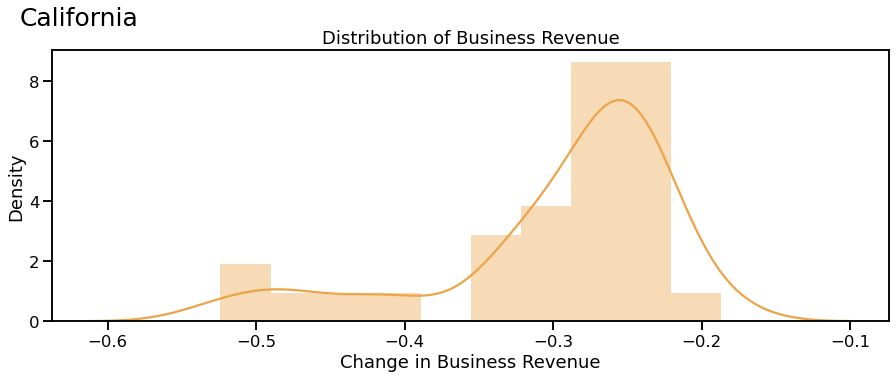

In [67]:
fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle('California', fontsize=25, x=0.15, y=1, verticalalignment='top')

# California business revenue distribution

c_rev = sns.distplot(c_merge['revenue_all'], bins=10, color='#eda44a').set_title('Distribution of Business Revenue', fontsize=23)
plt.xlabel("Change in Business Revenue", fontsize=18)
plt.ylabel("Density", fontsize=18)

Text(0, 0.5, 'Density')

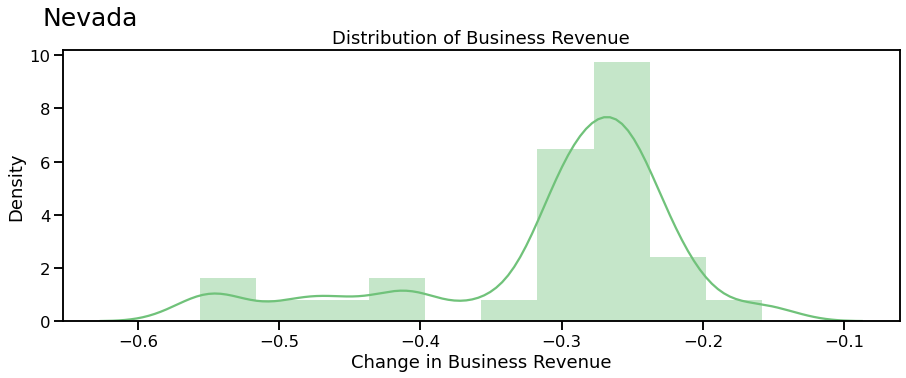

In [68]:
fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle('Nevada', fontsize=25, x=0.15, y=1, verticalalignment='top')

# Nevada business revenue distribution

n_rev = sns.distplot(n_merge['revenue_all'], bins=10, color='#70c27a').set_title('Distribution of Business Revenue', fontsize=23)
plt.xlabel("Change in Business Revenue", fontsize=18)
plt.ylabel("Density", fontsize=18)

In [69]:
# Normal test for business revenue and government response for Utah, California, Nevada
st_u_rev, p_u_rev = stats.normaltest(u_merge['revenue_all'].values)
st_c_rev, p_c_rev = stats.normaltest(c_merge['revenue_all'].values)
st_n_rev, p_n_rev = stats.normaltest(n_merge['revenue_all'].values)

print('Utah business revenue normal test p-value: ' + str(p_u_rev))
print('California business revenue normal test p-value: ' + str(p_c_rev))
print('Nevada business revenue normal test p-value: ' + str(p_n_rev))

Utah business revenue normal test p-value: 0.09824685872685798
California business revenue normal test p-value: 0.0018755660954061463
Nevada business revenue normal test p-value: 0.004963358554721965


When analyzing small business revenue and the government response indexes, only Utah passes the test for normality with an alpha value of 0.01 while Nevada and California do not. After observing the details of the distribution plots, we can see that the distribution of the states are similar in that they are skewed left; this is likely due to the pandemic influencing the spending habits of consumers and that small business revenue fell at the height of the pandemic so there are outliers that have greater (negative) magnitude relative to the other data points. 

These outlier values fall in the -.4 to -.6 range for California and Nevada which could indicate that small business's suffered more in more urban areas with larger populations. Although we didn't pass the test for normality for California or Nevada, we are aware that the OLS regression may not be completely accurate and will still proceed.  

In [70]:
outcome_rev_u, predictors_rev_u = patsy.dmatrices('revenue_all ~ GovernmentResponseIndexForDisplay', u_merge)
mod_rev_u = sm.OLS(outcome_rev_u, predictors_rev_u)
res_rev_u = mod_rev_u.fit()

In [71]:
print(res_rev_u.summary())

                            OLS Regression Results                            
Dep. Variable:            revenue_all   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                  0.002255
Date:                Sun, 13 Dec 2020   Prob (F-statistic):              0.962
Time:                        21:28:31   Log-Likelihood:                 46.507
No. Observations:                  31   AIC:                            -89.01
Df Residuals:                      29   BIC:                            -86.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

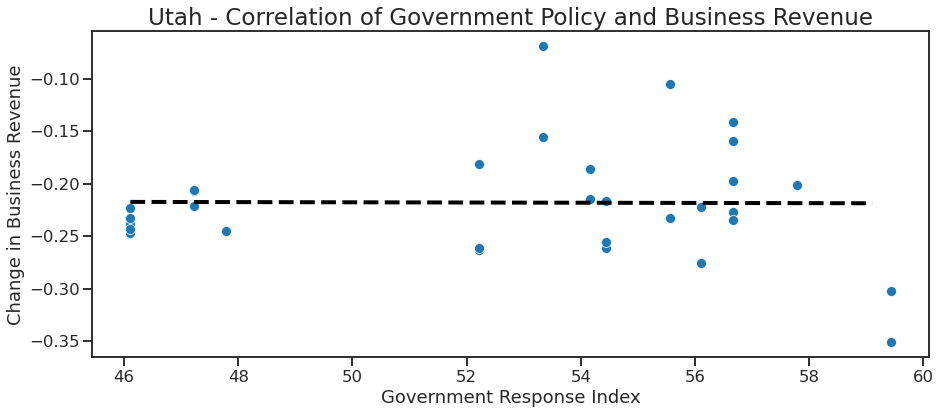

In [79]:
# Plot best fit line
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(15,6))
    sns.scatterplot(x='GovernmentResponseIndexForDisplay', y='revenue_all', data=u_merge, s=100).set_title('Utah - Correlation of Government Policy and Business Revenue', fontsize=23)
    plt.xlabel('Government Response Index')
    plt.ylabel('Change in Business Revenue')
    x_rev_u = np.arange(u_merge['GovernmentResponseIndexForDisplay'].min(), u_merge['GovernmentResponseIndexForDisplay'].max())
    y_rev_u = -0.0001 * x_rev_u -0.2125
    plt.plot(x_rev_u, y_rev_u, '--k',linewidth=4)

Observing a low r-squared value of 0.000 and p-value > 0.01 suggests that our model has no predictive power and we accept the null hypothesis that there is no relationship between Utah's small business revenue and its government response index.


In [73]:
outcome_rev_n, predictors_rev_n = patsy.dmatrices('revenue_all ~ GovernmentResponseIndexForDisplay', n_merge)
mod_rev_n = sm.OLS(outcome_rev_n, predictors_rev_n)
res_rev_n = mod_rev_n.fit()

In [74]:
print(res_rev_n.summary())

                            OLS Regression Results                            
Dep. Variable:            revenue_all   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     7.853
Date:                Sun, 13 Dec 2020   Prob (F-statistic):            0.00895
Time:                        21:28:31   Log-Likelihood:                 33.112
No. Observations:                  31   AIC:                            -62.22
Df Residuals:                      29   BIC:                            -59.36
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

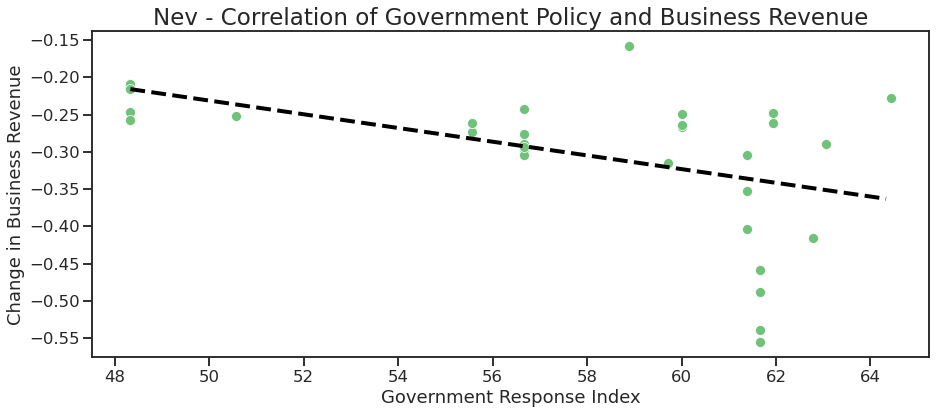

In [75]:
# Plot best fit line
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(15,6))
    sns.scatterplot(x='GovernmentResponseIndexForDisplay', y='revenue_all', data=n_merge, s=100, color='#70c27a').set_title('Nev - Correlation of Government Policy and Business Revenue', fontsize=23)
    plt.xlabel('Government Response Index')
    plt.ylabel('Change in Business Revenue')
    x_rev_n = np.arange(n_merge['GovernmentResponseIndexForDisplay'].min(), n_merge['GovernmentResponseIndexForDisplay'].max())
    y_rev_n = -0.0092 * x_rev_n + 0.2287
    plt.plot(x_rev_n, y_rev_n, '--k',linewidth=4)

Observing a low r-squared value of 0.213 and p-value < 0.01, we can reject the null hypothesis in favor of the alternative hypothesis. The r-squared value helps us predict 21.3% of the variation of small business revenue. We can conclude that there may be a relationship between the change in Nevada's small business revenue and the government response index from April 2020 to September 2020. However, this model may not be accurate as the distribution of small business revenue did not pass the test for normality.

In [76]:
outcome_rev_c, predictors_rev_c = patsy.dmatrices('revenue_all ~ GovernmentResponseIndexForDisplay', c_merge)
mod_rev_c = sm.OLS(outcome_rev_c, predictors_rev_c)
res_rev_c = mod_rev_c.fit()

In [77]:
print(res_rev_c.summary())

                            OLS Regression Results                            
Dep. Variable:            revenue_all   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     11.72
Date:                Sun, 13 Dec 2020   Prob (F-statistic):            0.00187
Time:                        21:28:31   Log-Likelihood:                 38.958
No. Observations:                  31   AIC:                            -73.92
Df Residuals:                      29   BIC:                            -71.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

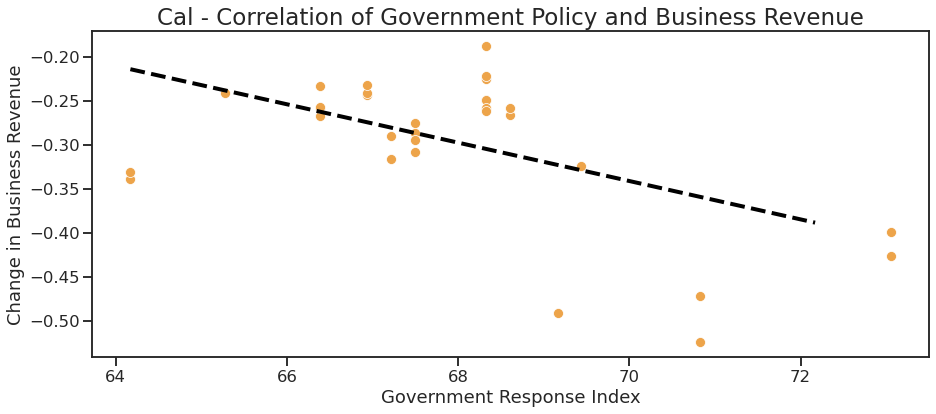

In [78]:
# Plot best fit line
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(15,6))
    sns.scatterplot(x='GovernmentResponseIndexForDisplay', y='revenue_all', data=c_merge, s=100, color='#eda44a').set_title('Cal - Correlation of Government Policy and Business Revenue', fontsize=23)
    plt.xlabel('Government Response Index')
    plt.ylabel('Change in Business Revenue')
    x_rev_c = np.arange(c_merge['GovernmentResponseIndexForDisplay'].min(), c_merge['GovernmentResponseIndexForDisplay'].max())
    y_rev_c = -0.0218 * x_rev_c + 1.1855
    plt.plot(x_rev_c, y_rev_c, '--k',linewidth=4)

Observing a low r-squared value of 0.288 and p-value < 0.01, we can reject the null hypothesis in favor of the alternative hypothesis. The r-squared value helps us predict 28.8% of the variation of small business revenue. We can conclude that there may be a relationship between the change in California's small business revenue and the government response index from April 2020 to September 2020. However, this model may not be accurate as the distribution of small business revenue did not pass the test for normality.

Overall, due to low r-squared values and lack of normality for some of our data, we cannot say there was a correlation between California, Nevada, and Utah's government policy and small business revenue.

# Ethics & Privacy

We have permission to access COVID-19 policy data because they are made public due to their direct effect on societal decisions through policies such as social distancing and business shut-down. <br> 

Additionally, there are privacy concerns we need to take into consideration for this project. While we do need data to measure economic influencers, we do not need specific data on human subjects. This mitigates some privacy concerns that follow with using human subjects and concerns regarding personal information. The dataset on Economic Influencers acknowledges this issue by pointing out that using raw data on specific economic changes is more accurate in research, but anonymized and aggregated data is important in reducing the disclosure of specific private data. Although we are collecting unemployment data and consumer spending at a large level, there isn’t any personal identifiable information in these datasets either. <br>

It is also important to look at the dates in which a policy is implemented on a state-level in context of events which happen on the national level. For example, a state may implement measures at a different time than another due to differences in when a COVID-19 case was first reported. A state with an earlier recorded case would likely be prompted to respond to the pandemic earlier than a state without any yet recorded cases. Since local/state economies are influenced by country/global economies, looking at a state which implements a measure at the same time as a country-wide economic shift may make it seem like the shift in the local economy was caused by the COVID-19 policy, when it was possibly caused by some other event on the national level. <br>

One bias concerning the data is that the indicators for COVID-19 policies and indicators of the state of the economy may not be a complete picture of COVID-19 policy stringency and the state of the economy in general. For example for the economic tracker dataset, we used indicators such as unemployment claims, consumer spending data and others included for the state of the economy but this may not be fully comprehensive in measuring the economy as there are other factors such as GDP. <br>

It is important to also take into account selection biases in the data we use. For example, if economic indicators are calculated by only focusing on large businesses, the observations could be skewed because larger businesses in general would be more stable in their revenue as opposed to smaller, more volatile businesses. Similarly, data must also not be biased towards certain industries: over-representation of the tech industry for example could skew economics data to be more positive due to the availability of remote work, however businesses that rely more on labor and in-person interaction would be more adversely affected and thus have a more negative impact on the economy. A state such has California has more large and tech businesses, so we must remember that when drawing our conclusions. Similarly, we may also have to take into account the economic situation of a state prior to COVID-19. As found in our background research, affluent areas tend to follow COVID-19 policies, such as stay-at-home mandates, better than poorer areas. Poorer areas may need to go out and see more people, whether it be due to the lack of remote work jobs or due to differences in population density. This means that an area which was initially poor may be affected more by COVID-19 than an area which is more affluent. <br>

We handled these issues in our data by looking at changes over a long period of time (early 2020 to present) which generalized any smaller short-term biases found in the data such as small discrepancies between weeks. By analyzing changes as opposed to raw data, we can also protect the privacy of business data that could have the potential to be identified from raw datasets.


# Conclusion & Discussion

Due to COVID-19's profound influence on our lives, we wanted to look into its effects on the U.S. economy. Prior research suggests that economic status affects adherence to COVID-19 policy. Additionally, research shows that local policies did not have a profound effect on both COVID-19 rates and economy. Therefore, after going through several iterations of questions, we ended up looking at COVID-19 policy and small business revenue, consumer spending, and unemployment rates by the state-level, specifically in California, Nevada, and Utah. We chose these states as they had differing economic strength, implemented different policies at different times, and were relatively nearby to account for differences in a state's first COVID-19 case. We also chose to look at small business revenue as small, local businesses with less branches would have more trouble maintaining a customer base compared to larger, more widespread businesses. Additionally, we looked at consumer spending as it may be affected by social distancing policies and stay-at-home orders. Finally, we chose unemployment rates as it is tied to business closures and is an indicator of the current job market.

In our project, we were trying to find a relationship between California, Nevada, and Utah's COVID-19 policy and changes in their economy. Our hypothesis was that we would find a correlation between the strength of each state's government policies and their small business revenue, consumer spending, and unemployment rates, with the most direct correlation being with consumer spending. However, the outcome of our analysis showed that largely, there is no correlation between a state's government policy and their economic changes. We found correlation in Utah's unemployment rates and Nevada and California's small business revenue, but due to the data not being normal, we cannot say for certain there is a relationship. The only aspect that we found correlation in was Utah's consumer spending rate, but since this was the only state, it is not much support for our claim of a relationship between policy and economy. In the future, more analysis of other states' consumer spending rates would be needed to further explore if Utah's correlation is an outlier, or the norm. 

Since we only focused on state-wide policies and economic effects, our analysis is not specific to economic discrepancies in specific cities and areas. Also, some COVID-19 policies such as stay-at-home orders can differ between counties, so our findings can only tell us about California, Utah, and Nevada in general, not the more detailed areas. We also can't generalize our results to any other states because we only analyzed these areas which are unique in certain aspects (California has one of the highest populations and Utah has one of the lowest unemployment rates). 

One reason our results did not match our hypothesis is that there could be confounding factors that affect a state's economy, independent of their COVID-19 policy. For example, we did not take into account the types of businesses that make up a majority of each state: California, for instance, has more tech industries which could play a role in the state of their economy. Another possible reason that our results did not match the hypothesis was that we removed data from the early months of the pandemic. For example, when first investigating the business revenue distribution with data from January - March included, we found that there was a strong correlation between business revenue and government response index in the three states. However, after deciding to remove the data from the early months of the pandemic, the correlation became weaker and both California and Utah’s distributions did not pass the normal test. This may be due to the initial government response to the pandemic and the sudden confounding factors that affected small business revenue.

Overall, our results are rather surprising because we hypothesized that there would be a correlation between government response and the economic variables we chose to analyze. It is possible that using a different model from OLS regression would have changed our findings, since we often could not conclude there was a relationship because of our data being non-normal to begin with or could not explain a certain percentage of the variability in our data, despite often finding that our p-value was lower than the alpha we had set. To properly assess whether there is a relationship between government response and our economic variables, it is possible that further analysis needs to be done. Still, it’s interesting that we could not conclude there was a relationship between government response and our economic variables, as this might suggest that we could have used other variables that better convey the relationship between government response and the economy as a whole. It is also worth noting that we only analyzed three states as mentioned above, so there may be other states where government response and the economic variables we selected are more strongly correlated.

# Team Contributions

 - Hana Kim - Data exploration, analysis, ethics, conclusion, visualizations
 - Emily Jewik - Data exploration, analysis, ethics, conclusion, cleaning
 - Vivian Yan - Data exploration, analysis, ethics, conclusion, cleaning
 - Andrew Pham - Data exploration, analysis, ethics, conclusion, background
 - Edward De Leon - Data exploration, analysis, ethics, conclusion, background